# 2006 Pikes Peak 10 km Run

## Matthew Jacobsen
## 5/20/2021


### Objective:
Using the data provided, create a series of visualizations (e.g., charts, graphs, etc.) that answer the following questions regarding the results of the 2006 Pike’s Peak 10k Race:
1. What are the mean, median, mode, and range of the race results for all racers by gender?
2. Analyze the difference between gun and net time race results.
3. How much time separates Chris Doe from the top 10 percentile of racers of the same division?
4. Compare the race results of each division.

### Data Overview:
The data provided includes two separate text files containing tab-separated information about the different racers, with the different files representing different genders.  Within this dataset, there are a total of eight columns:
1. Place: The order in which each racer finished relative to racers of the same gender
2. Division/Total: Racers of the same gender and age group (Age groups include 0-14, 15-19, and then in tens [e.g. 20-29]), with the total number of racers in the same division.  
3. Number: The racers bib number
4. Name: The racers name
5. Age: The racers age
6. Hometown: The hometown of the racer
7. Gun Time: The elapsed time from the formal start of the race and when the racer crossed the finish line.
8. Net Time: The elapsed time from when the racer crossed the start until they crossed the finish line.
9. Pace: The racer's average time per mile during the race

As part of the analysis done below, I have added a tenth column, Gender, which indicated the racers gender.  This was included because I worked with all of the data in the same dataframe.

### Data Processing:
First, I loaded the data, processed and merged it into a single dataframe, while also normalizing the formats of each of the columns and data types.  When loading the data, there were several instances where tab separator was misplaced (indicative of data entry errors), which necessitated treating the incoming data as if it were text and processing it that way, as opposed to direct loading into a dataframe. Then, I used regular expressions to normalize the data for analysis.  

In [1]:
# Import packages for analysis and plotting
import pandas as pd
from datetime import timedelta, datetime
import re
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data in as a string from each text file
with open('MA_Exer_PikesPeak_Females.txt','r') as infile:
    female_data = infile.read()

with open('MA_Exer_PikesPeak_Males.txt','r') as infile:
    male_data = infile.read()
    
# Separate the string based on carriage returns
female_data = female_data.split('\n')
male_data = male_data.split('\n')

# Segment the data and append to an overall data list, while including the Gender information
data_list = [['Place','Division/Total','Num','Name','Age','Hometown','Gun Time','Net Time','Pace','Gender']]
for line in female_data[1:]:
    new_line = line.split('\t')
    new_line.append('Female')
    data_list.append(new_line)
for line in male_data[1:]:
    new_line = line.split('\t')
    new_line.append('Male')
    data_list.append(new_line)

# Convert the list to a dataframe
df = pd.DataFrame(data_list[1:], columns = data_list[0])
df = df.dropna()

# Define our expected data formats for each column and use regular expressions to clean up the columns
char_mapping = ['[^0-9]+','[^0-9/]+','[^0-9]+','[^A-Za-z ]+','[^0-9]+','[^A-Za-z ]+','[^0-9:]+','[^0-9:]+','[^0-9:]+']
for i, char in enumerate(char_mapping):
    column = df.columns[i]
    df[column] = df[column].apply(lambda x: re.sub(char, '', x))
    if ('0-9' in char) and (':' not in char) and ('/' not in char):
        df[column] = df[column].apply(lambda x: int(x) if x!='' else -1)

# Look at the output to ensure it is what we expect.
df.head()

,Place,Division/Total,Num,Name,Age,Hometown,Gun Time,Net Time,Pace,Gender
0,1,1/86,30,Florence Jepkosgei,22,Kenya,32:59,32:58,5:19,Female
1,2,2/86,8,Eunice Chepkirui,21,Kenya,33:14,33:13,5:21,Female
2,3,1/247,3200,Elena Orlova,36,Gaithersburg MD,34:26,34:25,5:33,Female
3,4,1/173,2,Susannah Kvasnicka,34,Great Falls VA,34:43,34:42,5:35,Female
4,5,1/142,6,Casey Smith,26,Arlington VA,35:04,35:02,5:39,Female


Next, I want to work with straight numbers instead of times, as this will make the math and segmentation easier down the road.  For this, I'll convert all of the times in the Gun Time, Net Time, and Pace columns to number of seconds using stright slices, integer conversion, and summation.  If there is a value that is empty, I'll fill it with -1, so that it can be ignored later. 

In [3]:
# Convert the text Gun Time, Net Time, and Paces to numerical seconds
df['Gun Time'] = df['Gun Time'].apply(lambda x: int(x[:x.find(':')])*60+int(x[x.find(':')+1:x.find(':')+3]) if x != '' else -1)
df['Net Time'] = df['Net Time'].apply(lambda x: int(x[:x.find(':')])*60+int(x[x.find(':')+1:x.find(':')+3]) if x != '' else -1)
df['Pace'] = df['Pace'].apply(lambda x: int(x[:x.find(':')])*60+int(x[x.find(':')+1:x.find(':')+3]) if x != '' else -1)
df.head()

,Place,Division/Total,Num,Name,Age,Hometown,Gun Time,Net Time,Pace,Gender
0,1,1/86,30,Florence Jepkosgei,22,Kenya,1979,1978,319,Female
1,2,2/86,8,Eunice Chepkirui,21,Kenya,1994,1993,321,Female
2,3,1/247,3200,Elena Orlova,36,Gaithersburg MD,2066,2065,333,Female
3,4,1/173,2,Susannah Kvasnicka,34,Great Falls VA,2083,2082,335,Female
4,5,1/142,6,Casey Smith,26,Arlington VA,2104,2102,339,Female


Since we already know there were data entry errors, I will create a couple of columns to flag the data entry errors.  There are a couple of approaches for doing this:
1. We can assume that the pace times are all accurate and fill the Net Time based upon that, if Net Time is empty.  However, if the pace times are inaccurate, this will create false data.  This approach will also not help with the Gun Time, as that has an inherent delay that we cannot account for.
2. We can drop any values that are empty.  This approach reduces the data we have available, but it avoids making bad assumptions or misreporting results.

Given that there are 2370 records, I think we can afford to lose some data over making bad conclusions.

In [4]:
df['Expected Net Time'] = 10*0.621371*df['Pace'] # Calculate the expected net time, based upon a 10K race at the pace recorded
df['Error'] = (df['Expected Net Time']/df['Net Time']) # Determine the percentage of the recorded net time the expected net time is
df['Err Flag'] = ~df['Error'].between(0.9,1.1) # Flag all records where the expected net time is more than 10% off from the recorded net time
df.head()

,Place,Division/Total,Num,Name,Age,Hometown,Gun Time,Net Time,Pace,Gender,Expected Net Time,Error,Err Flag
0,1,1/86,30,Florence Jepkosgei,22,Kenya,1979,1978,319,Female,1982.17349,1.002110,False
1,2,2/86,8,Eunice Chepkirui,21,Kenya,1994,1993,321,Female,1994.60091,1.000803,False
2,3,1/247,3200,Elena Orlova,36,Gaithersburg MD,2066,2065,333,Female,2069.16543,1.002017,False
3,4,1/173,2,Susannah Kvasnicka,34,Great Falls VA,2083,2082,335,Female,2081.59285,0.999804,False
4,5,1/142,6,Casey Smith,26,Arlington VA,2104,2102,339,Female,2106.44769,1.002116,False


We have the added problem of having ages that are outside of the possible range (e.g. less than zero).  If we remove all of those, how much data to we retain, along with eliminating those records that show a significant error in the net time and pace values. 

In [5]:
df = df[df['Age']>0]
print(len(df), len(data_list))
df = df[df['Err Flag'] == False]
print(len(df), len(data_list))

2366 2373
1759 2373


If we drop all the data that is outside of our expected ranges, we retain about 75% of the overall results.  The benefit of doing this is that we will be using data that meets reasonable expectations for data quality and ranges.  Now we can move into the questions.

### Question 1: What are the mean, median, mode, andrange of the race results for all racers by gender?

The best way to visualize the answer to this question is through use of a box plot.  Box plots can display, by default, the range, mean, and median values by gender.  With some straightforward functions, we can also include the mode value for all racers. The graphic answering this question is shown below.  

<function matplotlib.pyplot.show(close=None, block=None)>

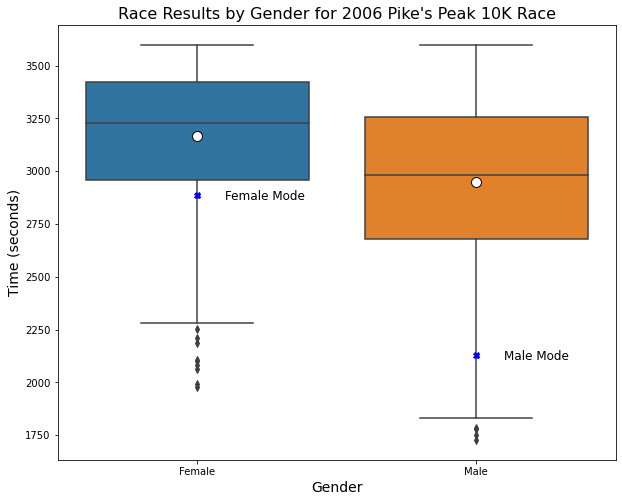

In [74]:
# Section off the data we want for plotting
data = df[['Gun Time','Net Time','Gender','Pace']].copy()

### Create our X and Y data for the mode value addition to our plot.
# Create X data
positions = np.arange(2)

# Use scipy.stats's mode function to obtain the mode value for the net time
modes = []
for x in data['Gender'].unique():
    mode = stats.mode(data[data['Gender']==x]['Net Time'])
    modes.append(mode.mode[0])
    
# Create our plot variables
fig, ax = plt.subplots(1,1,figsize=(10,8))
# Use Seaborn's boxplot to plot the Net Time by Gender and include the mean values on plot
sns.boxplot(x='Gender', 
            y='Net Time', 
            data=data, 
            showmeans=True,
            meanprops={"marker":"o",
                      "markerfacecolor":"white",
                      "markeredgecolor":"black",
                      "markersize":"10"}
           )
# Add the mode values to plot
ax.plot(positions,modes, 'bX')
# Label the modes
ax.text(positions[0]+0.1, modes[0]-20, 'Female Mode', size=12)
ax.text(positions[1]+0.1, modes[1]-20, 'Male Mode', size=12)
# Put the axis labels on the plot
plt.ylabel('Time (seconds)', size=14)
plt.xlabel('Gender',size=14)
# Put the chart title on the plot
plt.title("Race Results by Gender for 2006 Pike's Peak 10K Race", size=16)
plt.show

In [75]:
for gender in data['Gender'].unique():
    print('For the {} racers:'.format(gender))
    sub_df = data[data['Gender']==gender]
    mean = np.mean(sub_df['Net Time'])
    median = np.median(sub_df['Net Time'])
    mode = stats.mode(sub_df['Net Time'])
    mode = mode[0]
    ran = [sub_df['Net Time'].max(), sub_df['Net Time'].min()]
    print('The mean is {}, the median is {}, the mode is {}, the range is {}.'.format(mean, median, mode, ran))

For the Female racers:
The mean is 3167.7661406025827, the median is 3226.0, the mode is [2886], the range is [3599, 1978].
For the Male racers:
The mean is 2948.845574387947, the median is 2981.0, the mode is [2128], the range is [3597, 1727].


### Question 2: Analyze the difference between gun and net time race results.

In order to comment on the difference between gun and net time race results, we can look at statistical variation in the results, similar to what we did for the previous question. Before we do that, let's see if we can gain some insight about what might be going on here.  

In [76]:
data['Diff Time'] = data['Gun Time'] - data['Net Time']
data.head()

,Gun Time,Net Time,Gender,Pace,Diff Time
0,1979,1978,Female,319,1
1,1994,1993,Female,321,1
2,2066,2065,Female,333,1
3,2083,2082,Female,335,1
4,2104,2102,Female,339,2


<AxesSubplot:>

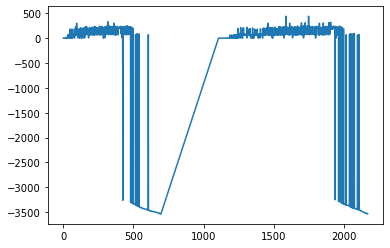

In [77]:
data['Diff Time'].plot()

In this graph, we look at the difference between the gun time and the net time.  For most of the racers, there is minimal difference, on the order of a few hundred seconds.  However, there is a large group where the gun time is significantly less than the Net Time.  This, as with our original results, indicates either data entry errors or some inconsistency we have not accounted for.  Based upon our previous analysis, the net times are likely not the problem, since we already used the Pace to cross check for anomalous values outside of a 10% range.

We did not do this for the Gun time though.  At this point, one possibility is that there are racers that ran the race **before** it officially started.  Since the gun time is the from when the race officially started and when the racer crossed the finish line, a large negative number would be expected in that situation.  Since we have no way to identify those points, the most sound approach is to exclude them, as they create noise that we cannot reasonably accomodate.

<AxesSubplot:>

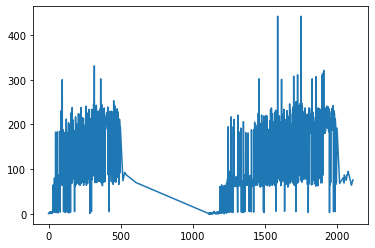

In [78]:
new_data = data[data['Diff Time'] >= 0].copy()
new_data['Diff Time'].plot()

Now, we should be ok to run statistical comparisons between the data and know that our results should be somewhat consistent.

<function matplotlib.pyplot.show(close=None, block=None)>

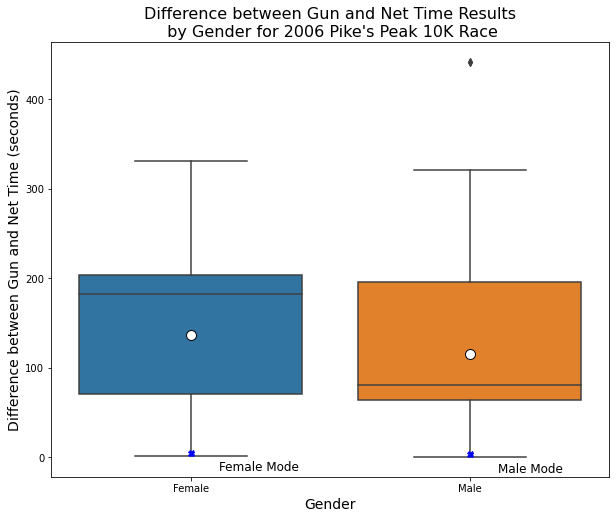

In [79]:
# Section off the data we want for plotting
data = new_data[['Diff Time','Gender','Pace']].copy()

### Create our X and Y data for the mode value addition to our plot.
# Create X data
positions = np.arange(2)

# Use scipy.stats's mode function to obtain the mode value for the net time
modes = []
for x in data['Gender'].unique():
    mode = stats.mode(data[data['Gender']==x]['Diff Time'])
    modes.append(mode.mode[0])
    
# Create our plot variables
fig, ax = plt.subplots(1,1,figsize=(10,8))
# Use Seaborn's boxplot to plot the Net Time by Gender and include the mean values on plot
sns.boxplot(x='Gender', 
            y='Diff Time', 
            data=data, 
            showmeans=True,
            meanprops={"marker":"o",
                      "markerfacecolor":"white",
                      "markeredgecolor":"black",
                      "markersize":"10"}
           )
# Add the mode values to plot
ax.plot(positions,modes, 'bX')
# Label the modes
ax.text(positions[0]+0.1, modes[0]-20, 'Female Mode', size=12)
ax.text(positions[1]+0.1, modes[1]-20, 'Male Mode', size=12)
# Put the axis labels on the plot
plt.ylabel('Difference between Gun and Net Time (seconds)', size=14)
plt.xlabel('Gender',size=14)
# Put the chart title on the plot
plt.title("Difference between Gun and Net Time Results\n by Gender for 2006 Pike's Peak 10K Race", size=16)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

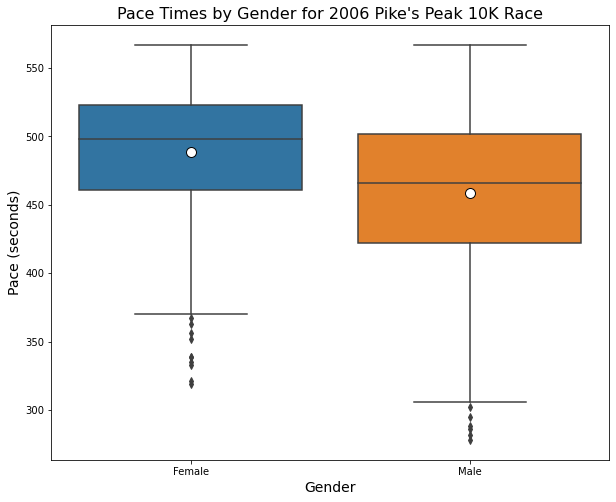

In [81]:
# Section off the data we want for plotting
data = new_data[['Diff Time','Gender','Pace']].copy()

### Create our X and Y data for the mode value addition to our plot.
# Create X data
positions = np.arange(2)

# Use scipy.stats's mode function to obtain the mode value for the net time
modes = []
for x in data['Gender'].unique():
    mode = stats.mode(data[data['Gender']==x]['Diff Time'])
    modes.append(mode.mode[0])
    
# Create our plot variables
fig, ax = plt.subplots(1,1,figsize=(10,8))
# Use Seaborn's boxplot to plot the Net Time by Gender and include the mean values on plot
sns.boxplot(x='Gender', 
            y='Pace', 
            data=data, 
            showmeans=True,
            meanprops={"marker":"o",
                      "markerfacecolor":"white",
                      "markeredgecolor":"black",
                      "markersize":"10"}
           )
# Add the mode values to plot
#ax.plot(positions,modes, 'bX')
# Label the modes
#ax.text(positions[0]+0.1, modes[0]-20, 'Female Mode', size=12)
#ax.text(positions[1]+0.1, modes[1]-20, 'Male Mode', size=12)
# Put the axis labels on the plot
plt.ylabel('Pace (seconds)', size=14)
plt.xlabel('Gender',size=14)
# Put the chart title on the plot
plt.title("Pace Times by Gender for 2006 Pike's Peak 10K Race", size=16)
plt.show

### Question 3: How much time separates Chris Doe fromthe top 10 percentile of racers of the same division?

In order to answer this question, we need to first know where Chris Doe sits in the data.  This can be easily done by searching the dataframe for the index associated with that name. 

In [14]:
position = df[df['Name'] == 'Chris Doe'].index
position

Int64Index([1640], dtype='int64')

Next, since the divisions are age based, I need to know Chris's age and then we can narrow down our analysis to just those racers in the same age division, regardless of gender.

In [15]:
df['Age'][1640]

44

In [16]:
sub_df = df[df['Age'].between(40,49)].copy()
sub_df

,Place,Division/Total,Num,Name,Age,Hometown,Gun Time,Net Time,Pace,Gender,Expected Net Time,Error,Err Flag
5,6,1/110,28,Lyubov Kremleva,45,Russia,2105,2104,339,Female,2106.44769,1.001163,False
14,15,2/110,834,Cindy Conant,45,Kensington MD,2376,2374,382,Female,2373.63722,0.999847,False
16,17,1/173,2013,Laura Nelson,40,Woodstock VA,2388,2385,384,Female,2386.06464,1.000446,False
18,19,2/173,1596,Sheryl Kline,43,Arnold MD,2408,2405,387,Female,2404.70577,0.999878,False
23,24,3/110,2940,Liliana Baron,47,Potomac MD,2446,2443,394,Female,2448.20174,1.002129,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155,1050,187/214,2845,Jeffrey Zavadil,40,Rockville MD,63,3584,577,Male,3585.31067,1.000366,False
2161,1056,168/201,2000,Mark Nagurney,47,Laurel MD,64,3591,578,Male,3591.52438,1.000146,False
2163,1058,169/201,764,Kim Chan,47,Brookeville MD,64,3593,579,Male,3597.73809,1.001319,False
2164,1059,170/201,2256,Jonathan Reiner,46,Potomac MD,63,3593,579,Male,3597.73809,1.001319,False


Next, I will add a columns that calculates the percentile block for each racer. From that subset of data, we can find the closest to the 10% percentile ranked racer, as well as Chris's time.  This can be done one of two ways:
1. Chris can be compared against the other male racers only
2. Chris can be compared against all races in the same age bracket

We will look at both of these possibilities.

In [17]:
sub_df['Percentile'] = (df['Net Time']/df['Net Time'].max()).rank(pct=True)
sub_df.head()

,Place,Division/Total,Num,Name,Age,Hometown,Gun Time,Net Time,Pace,Gender,Expected Net Time,Error,Err Flag,Percentile
5,6,1/110,28,Lyubov Kremleva,45,Russia,2105,2104,339,Female,2106.44769,1.001163,False,0.021603
14,15,2/110,834,Cindy Conant,45,Kensington MD,2376,2374,382,Female,2373.63722,0.999847,False,0.063957
16,17,1/173,2013,Laura Nelson,40,Woodstock VA,2388,2385,384,Female,2386.06464,1.000446,False,0.067084
18,19,2/173,1596,Sheryl Kline,43,Arnold MD,2408,2405,387,Female,2404.70577,0.999878,False,0.073621
23,24,3/110,2940,Liliana Baron,47,Potomac MD,2446,2443,394,Female,2448.20174,1.002129,False,0.081296


In [18]:
ten_percentile_time = sub_df[sub_df['Percentile']<=0.1]['Net Time'].max()
ten_percentile_time

2515

In [21]:
ten_percentile_time_male = sub_df[(sub_df['Percentile']<=0.1) & (sub_df['Gender']=='Male')]['Net Time'].max()
ten_percentile_time_male

2515

In [22]:
cd_time = df['Net Time'][1640]
cd_time

2983

Finally, we can use a histogram plot of the times to illustrate where the 10th percentile is for both genders and males only against Chris's time.  In this case, since the slowest racer in the top 10 percent was obviously male, there is no difference when we include gender, so we don't need additions to the graph, but the lines that would do this (had there been a difference) are commented out.

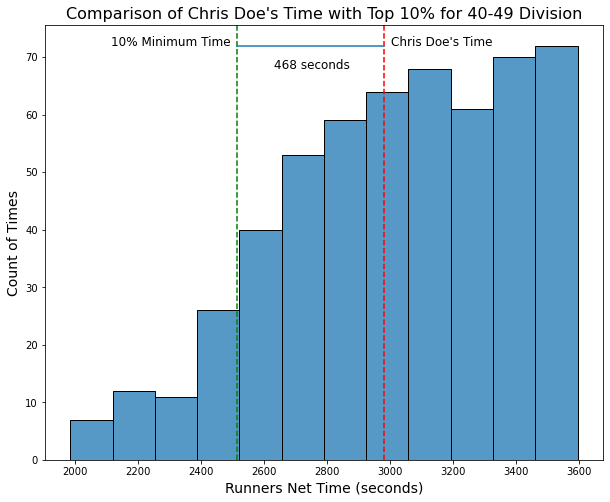

In [63]:
#Set up the plot variables
fig, ax = plt.subplots(1,1,figsize=(10,8))

#Plot our histogram
sns.histplot(data=sub_df, x='Net Time')

#Add vertical lines for our tenth percentiles and Chris's time
plt.axvline(x=cd_time, color='r', linestyle='--')
plt.axvline(x=ten_percentile_time, color='g', linestyle='--')
#plt.axvline(x=ten_percentile_time_male, color='k', linestyle='--')

#Add a spanning line for each of these possibilities
plt.plot([ten_percentile_time,cd_time],[72,72])
#plt.plot([ten_percentile_time_male,cd_time],[65,65])

#Label our axes and title our plot
plt.xlabel('Runners Net Time (seconds)', size=14)
plt.ylabel('Count of Times', size=14)
plt.title("Comparison of Chris Doe's Time with Top 10% for 40-49 Division", size=16)

#Label our vertical lines
ax.text(cd_time+20, 72, "Chris Doe's Time", size=12)
ax.text(ten_percentile_time-400, 72, '10% Minimum Time', size=12)
#ax.text(ten_percentile_time-500, 65, '10% Minimum Time - Males', size=12)

#Put the time delta on the graph for each possibility
ax.text(ten_percentile_time+(cd_time-ten_percentile_time)/4, 68, '{} seconds'.format(cd_time-ten_percentile_time), size=12)
#ax.text(ten_percentile_time_male+(cd_time-ten_percentile_time_male)/4, 62, '{} seconds'.format(cd_time-ten_percentile_time_male), size=12)

#Plot the graph
plt.show()

### Question 4: Compare the race results of each division.

In order to answer this question, we need to get the results of each division.  So that we don't end up making too many divisions, let's first see how old the oldest racer is.

In [13]:
df['Age'].max()

78

So our oldest racer would be in the 70-79 division.  Now, we can make our divisions in accordance with the data description we have.  Then, what we want to do is to create a column that indicates the division that each racer would be in.

In [31]:
divisions = [
    df['Age'].between(0,14), 
    df['Age'].between(15,19),
    df['Age'].between(20,29),
    df['Age'].between(30,39),
    df['Age'].between(40,49),
    df['Age'].between(50,59),
    df['Age'].between(60,69),
    df['Age'].between(70,79)
]

values = ["0-14",'15-19','20-29','30-39','40-49','50-59','60-69','70-79']

df['Division'] = np.select(divisions, values, 0)
df.head()

,Place,Division/Total,Num,Name,Age,Hometown,Gun Time,Net Time,Pace,Gender,Expected Net Time,Error,Err Flag,Division
0,1,1/86,30,Florence Jepkosgei,22,Kenya,1979,1978,319,Female,1982.17349,1.002110,False,20-29
1,2,2/86,8,Eunice Chepkirui,21,Kenya,1994,1993,321,Female,1994.60091,1.000803,False,20-29
2,3,1/247,3200,Elena Orlova,36,Gaithersburg MD,2066,2065,333,Female,2069.16543,1.002017,False,30-39
3,4,1/173,2,Susannah Kvasnicka,34,Great Falls VA,2083,2082,335,Female,2081.59285,0.999804,False,30-39
4,5,1/142,6,Casey Smith,26,Arlington VA,2104,2102,339,Female,2106.44769,1.002116,False,20-29


Now, we can look at the statistics for each division, which should give us a good view of what we are dealing with.  We will avoid the mode values for now, as those are more likely to clutter up and degrade our visualization.

<function matplotlib.pyplot.show(close=None, block=None)>

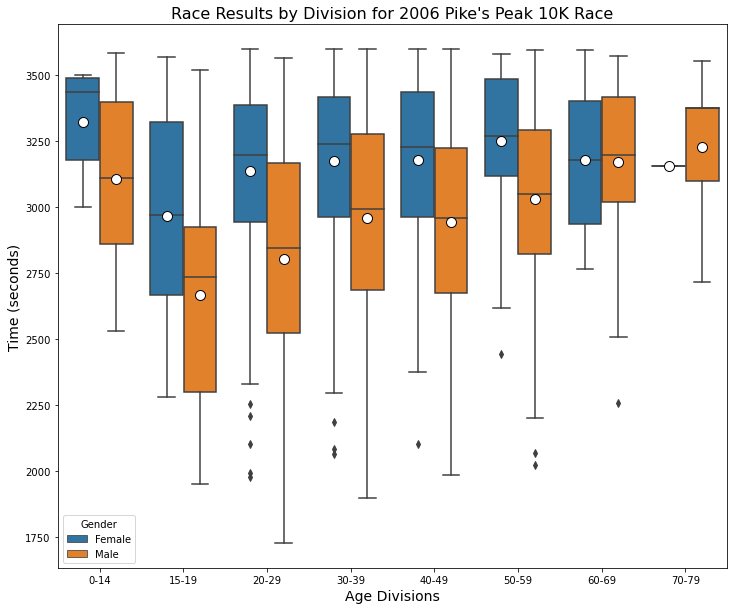

In [59]:
# Section off the data we want for plotting
data = df[['Gender','Division','Net Time']].copy()

#data_long = pd.melt(data, id_vars="Gender", var_name='Gender')

# Create our plot variables
fig, ax = plt.subplots(1,1,figsize=(12,10))
# Use Seaborn's boxplot to plot the Net Time by Gender and include the mean values on plot
sns.boxplot(x='Division', 
            hue='Gender',
            y='Net Time', 
            order=values,
            data=data, 
            showmeans=True,
            meanprops={"marker":"o",
                      "markerfacecolor":"white",
                      "markeredgecolor":"black",
                      "markersize":"10"}
           )

# Put the axis labels on the plot
plt.ylabel('Time (seconds)', size=14)
plt.xlabel('Age Divisions',size=14)
# Put the chart title on the plot
plt.title("Race Results by Division for 2006 Pike's Peak 10K Race", size=16)
plt.show

So we can see that the fastest runners are in the 20-29 age division for males and females.  In general, male runners tend to peak in that age division and then taper off with age.  In contrast, female runners maintain similar low times across the 20-59 age range.  